<a href="https://colab.research.google.com/github/rgmantovani/advancedML/blob/master/codes/aula_02b_mlp/MLP_exemplo2_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perceptron Multicamadas (*Multilayer Perceptron - MLP*)

Disciplina: Métodos e Modelos Avançados em Ciência de Dados

Especialização em Ciência de Dados - Universidade Tecnologica Federal do Paraná

Aula 01B: Perceptron Multicamadas (MLP)

Exemplo 02: Executando MLP no Iris (problema multiclasse)

Prof. Dr. Rafael Gomes mantovani

---

In [6]:
# Adicionando um seed para reproducibilidade do exemplo 
set.seed(42)

Para termos uma MLP própria, iremos codificar algumas funções:

* **mlp.create**: instancia uma MLP recebendo alguns parâmetros para determinar sua arquitetura (topologia); 
* **mlp.forward**: propaga o sinal (exemplo) recebido, ativando os neurônios da camada de entrada até a camada de saída;
* **mlp.train**: treina a MLP em um conjunto de treinamento, passado como parâmetro para a rede
* **mlp.test**: faz a predição para os valores contidos em um novo conjunto de teste

Também iremos precisar de mais duas funções:
* **fnet**: uma função de ativação, contínua e derivável
* **dfnet**: a função derivada da função de ativação, que irá ser usada para computar os gradientes de ajuste dos pesos sinápticos entre as camadas da MLP

In [7]:
# -----------------------------------------------------------------
# Função de ativaçao e sua função derivada
#   - v é o sinal recebido pelo neurônio/unidade
# -----------------------------------------------------------------

# função de ativaçao sigmoidal
fnet = function(v){
  return (1 / (1+exp(-v)))
}

# função derivada de fnet (fnet já está computado para o sinal v)
# quando chamamos ela dentro do treinamento da MLP, fnet é um vetor
dfnet = function(f_net){
  return (f_net * (1 - f_net))
} 


In [8]:
# -----------------------------------------------------------------
# Inicialização do modelo (MLP)
#   - input.length: tamanho da camada de entrada
#   - hidden.length: quantidade de neurônios da camada oculta
#   - output.length: quantidad de
# -----------------------------------------------------------------

mlp.create = function(input.length = 2, hidden.length = 2,
  output.length = 1) {

  # cria um objeto (modelo) para retornarmos no fim da função
  model = list()
  
  # instanciar a topologia da rede
  model$input.length  = input.length
  model$hidden.length = hidden.length
  model$output.length = output.length

  # salvamos também as funcoes no modelo
  model$fnet  = fnet
  model$dfnet = dfnet
  
  # criamos pesos 'ocultos' nas nossas unidades (bias)
  # e geramos os pesos aleatoriamente com valores entre [-0.5, 0.5]
  # isso vai ser salvo em uma matriz (hidden), sao os pesos sinápticos
  # entre a camada de entrada e a camada oculta
  # 		X1	     X2    Bias
  # 1   w11     w12    w13
  # 2 	w21     w22    w23
  wh = runif(min = -0.5, max = 0.5, n = hidden.length * (input.length + 1))
  model$hidden = matrix(data = wh, nrow = hidden.length, ncol = input.length + 1)

  # repetimos o processo anterior mas agora criando pesos sinápticos entre
  # a camada coluta e a camada de saida
  wo = runif(min = -0.5, max = 0.5, n = output.length * (hidden.length + 1))
  model$output = matrix(data = wo, nrow = output.length, ncol = hidden.length + 1)

  # retornamos nosso objeto (modelo), com toda essa informação gerada
  return(model)
}


In [9]:
# -----------------------------------------------------------------
# propaga o sinal pela MLP da camada de entrada até a saída (forward)
#   - model:   modelo criado pela função mlp.create
#   - example: um exemplo/instância/linha do dataset de treinamento
# -----------------------------------------------------------------

mlp.forward = function(model, example) {

  # propaga o sinal da entrada para a camada oculta
  # adicionamos um sinal positivo para o bias (+1)
  net.hidden  = model$hidden %*% as.numeric(c(example, 1))
  fnet.hidden = model$fnet(net.hidden)

  # propaga o sinal da camada oculta para a saída
  # adicionamos um sinal positivo para o bias (+1)
  net.output = model$output %*% c(as.numeric(fnet.hidden),1)
  fnet.output = model$fnet(net.output)

  # retornando os valores computados em cada camada
  res = list(net.hidden = net.hidden, fnet.hidden = fnet.hidden,
    net.output = net.output, fnet.output = fnet.output)

  return(res)
}


In [10]:
# -----------------------------------------------------------------
# Função para treinamento da MLP
#   - model:   modelo que instanciamos com mlp.create
#   - dataset: conjunto de treinamento
#   - lrn.rate: taxa de aprendizado
#   - threshold: taxa de erro aceitável para interromper o treinamento
#   - n.iter: número máximo de épocas para permitir o treinamento
# -----------------------------------------------------------------

mlp.train = function(model, dataset, lrn.rate = 0.1, threshold = 1e-3, 
   n.iter = 1000) {
  
  squaredError = 2 * threshold
  epochs = 0
  errorVec = c()
  
  # controla o numero de épocas, considerando também o erro 
  # quadrático da iteração
  while(squaredError > threshold & epochs < n.iter) {

    squaredError = 0
    
    # avaliamos todas as instâncias do dataset (época)
    for(p in 1:nrow(dataset)) {
      
      # acesar o exemplo corrente e seu rótulo (target/label)
      Xp = as.numeric(dataset[p,1:model$input.length])
      Yp = as.numeric(dataset[p,(model$input.length+1):ncol(dataset)])
      
      # movemos o sinal pela rede, usando mlp.forward
      res = mlp.forward(model = model, example = Xp)
      
      # obtemos a saída obtida (predita)
      Op  = res$fnet.output
      
      # obtemos a medida de erro do classificador
      error = (Yp - Op)
      
      # calculamos o erro quadrático para esse exemplo
      squaredError = squaredError + sum(error^2)
      
      # computamos delta.output (delta_o) - variaçao dos pesos na camada de saída
      # delta_o = (Yp - Op) * f'(net_output)
      delta.output = error * model$dfnet(Op)
    
      # computamos delta.hidden (delta_h) - variação dos pesos na camada oculta
      # delta_h = f'(net_hidden) * sum(delta_o * Wo)
      Wo = model$output[, 1:model$hidden.length]
      delta.hidden = as.numeric(model$dfnet(res$fnet.hidden)) * (as.numeric(delta.output) %*% Wo)
      
      # computamos os novos pesos sinápticos do modelo (Wo and Wh)
      new.W.output = model$output + lrn.rate * (delta.output %*% as.vector(c(res$fnet.hidden,1)))
      new.W.hidden = model$hidden + lrn.rate * (t(delta.hidden) %*% as.vector(c(Xp,1)))
      
      # atualizamos os pesos sinápticos da rede
      model$hidden = new.W.hidden
      model$output = new.W.output
    }
    
    # calculando o erro quadrático da época
    squaredError = squaredError / nrow(dataset)
    errorVec = c(errorVec, squaredError)
    epochs = epochs + 1
    cat("Época: ", epochs, "- Error: ", squaredError, "\n")
  }
  
  # returning o modelo treinado depois das épocas
  ret = list(model = model, epochs = epochs, errorVec = errorVec)
  return(ret)
}


In [11]:
# -----------------------------------------------------------------
# Função para realizar predições em exemplos de teste
#   - model:   model já treinado (depois de executar mlp.train)
#   - example: exemplo para ser predito
# -----------------------------------------------------------------
mlp.test = function(model, example) {
  res = mlp.forward(model = model, example = example)
  return(res)
}

In [13]:
# -----------------------------------------------------------------
# Carregando e manipulando o dataset Iris
# -----------------------------------------------------------------

dataset  = iris

# dividindo o label em 3 atributos-alvo
dataset$class.Setosa     = 0
dataset$class.Versicolor = 0
dataset$class.Virginica  = 0

# renomeando as categorias para valores numéricos
dataset$class.Setosa[which(dataset$Species == "setosa")] = 1
dataset$class.Versicolor[which(dataset$Species == "versicolor")] = 1
dataset$class.Virginica[which(dataset$Species == "virginica")] = 1

# removendo a antiga coluna com a classe
dataset$Species = NULL

In [2]:
dataset

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,class.Setosa,class.Versicolor,class.Virginica
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5.1,3.5,1.4,0.2,1,0,0
4.9,3.0,1.4,0.2,1,0,0
4.7,3.2,1.3,0.2,1,0,0
4.6,3.1,1.5,0.2,1,0,0
5.0,3.6,1.4,0.2,1,0,0
5.4,3.9,1.7,0.4,1,0,0
4.6,3.4,1.4,0.3,1,0,0
5.0,3.4,1.5,0.2,1,0,0
4.4,2.9,1.4,0.2,1,0,0


In [14]:
# -----------------------------------------------------------------
# Dividir os dados em conjuntos de treinamento e teste (holdout)
# -----------------------------------------------------------------

train.data = dataset[c( 1:30,  51:80, 101:130), ]
test.data  = dataset[c(31:50, 81:100, 131:150), ]

In [15]:
# -----------------------------------------------------------------
# Instanciando MLP
# -----------------------------------------------------------------

model = mlp.create(input.length = 4, hidden.length = 3, output.length = 3)

print(model)

$input.length
[1] 4

$hidden.length
[1] 3

$output.length
[1] 3

$fnet
function(v){
  return (1 / (1+exp(-v)))
}

$dfnet
function(f_net){
  return (f_net * (1 - f_net))
}

$hidden
           [,1]       [,2]       [,3]        [,4]        [,5]
[1,]  0.4148060 0.33044763  0.2365883  0.20506478  0.43467225
[2,]  0.4370754 0.14174552 -0.3653334 -0.04225822 -0.24457118
[3,] -0.2138605 0.01909595  0.1569923  0.21911225 -0.03770718

$output
           [,1]        [,2]       [,3]        [,4]
[1,]  0.4400145 -0.02500292 -0.3612898 -0.41756244
[2,]  0.4782264  0.06033275  0.4888917  0.01421178
[3,] -0.3825126  0.40403139  0.4466682 -0.10979653



In [17]:
# -----------------------------------------------------------------
# Treinando a MLP
# -----------------------------------------------------------------

# conjunto de treinamento = train.data
# taxa de aprendizado     = 0.1
# threshold de erro       = 0.01
# iteracoes maximas       = 1000


# defines the stopping criteria with and error < 0.001 and epochs < 100k
obj = mlp.train(model = model, dataset = train.data, lrn.rate = 0.1,
  threshold = 1e-2, n.iter = 10000)

Época:  1 - Error:  0.6652123 
Época:  2 - Error:  0.5969012 
Época:  3 - Error:  0.567845 
Época:  4 - Error:  0.5311588 
Época:  5 - Error:  0.4961386 
Época:  6 - Error:  0.461444 
Época:  7 - Error:  0.429712 
Época:  8 - Error:  0.4014381 
Época:  9 - Error:  0.3762474 
Época:  10 - Error:  0.3536025 
Época:  11 - Error:  0.332985 
Época:  12 - Error:  0.3139688 
Época:  13 - Error:  0.296244 
Época:  14 - Error:  0.279603 
Época:  15 - Error:  0.2639119 
Época:  16 - Error:  0.2490865 
Época:  17 - Error:  0.2350747 
Época:  18 - Error:  0.2218443 
Época:  19 - Error:  0.2093727 
Época:  20 - Error:  0.1976398 
Época:  21 - Error:  0.1866223 
Época:  22 - Error:  0.1762923 
Época:  23 - Error:  0.16662 
Época:  24 - Error:  0.157578 
Época:  25 - Error:  0.1491413 
Época:  26 - Error:  0.1412851 
Época:  27 - Error:  0.1339825 
Época:  28 - Error:  0.1272028 
Época:  29 - Error:  0.1209136 
Época:  30 - Error:  0.1150818 
Época:  31 - Error:  0.1096767 
Época:  32 - Error:  0.104

In [18]:
# -----------------------------------------------------------------
# criar dataframe com o historico do treinamento 
# (epoca - erro da epoca)
# -----------------------------------------------------------------

df = data.frame(1:length(obj$errorVec), obj$errorVec)
colnames(df) = c("epochs", "error")
head(df)

,epochs,error
,<int>,<dbl>
1,1,0.6652123
2,2,0.5969012
3,3,0.5678450
4,4,0.5311588
5,5,0.4961386
6,6,0.4614440


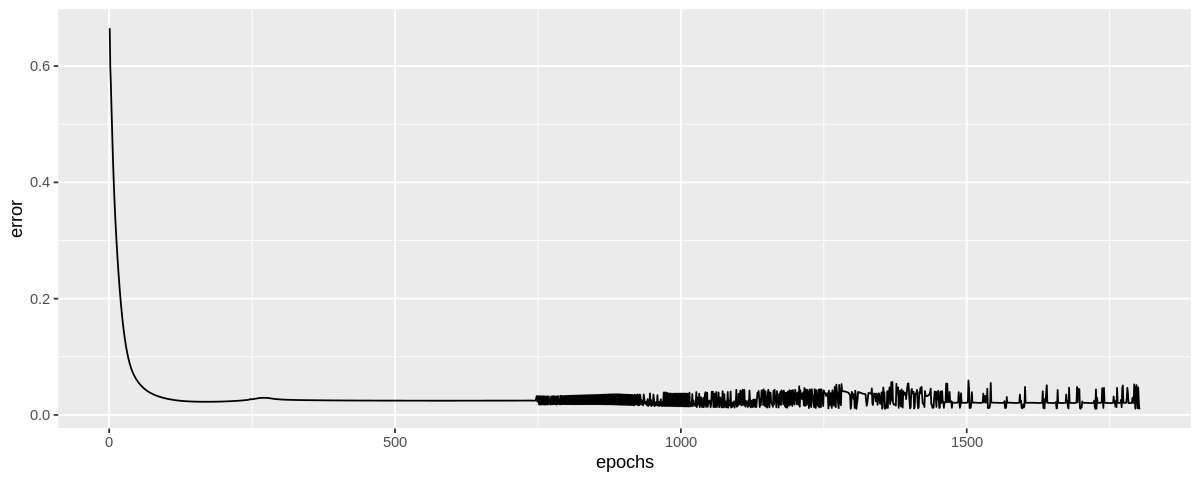

In [19]:
# -----------------------------------------------------------------
# Plotar a curva de convergência do erro de treinamento
# -----------------------------------------------------------------

# para gerar algumas análies gráficas vamos carregar o pacote ggplot2
library("ggplot2")

g = ggplot(df, aes(x = epochs, y = error))
g = g + geom_line() 
g = g + scale_x_continuous(limit = c(1, nrow(df)))

options(repr.plot.width=10, repr.plot.height=4)
print(g)


In [22]:
# -----------------------------------------------------------------
# Predizendo os valores para o conjunto de teste
# -----------------------------------------------------------------

# testando para cada exemplo no conjunto de teste
aux = lapply(1:nrow(test.data), function(i) {
  
  # for each example, it gets its prediction 
  pred = mlp.test(model = obj$model, example = test.data[i, 1:model$input.length])
 
  # returns the obtained output for each example
  ret = as.numeric(round(pred$fnet.output))
  return(ret)
})

print(aux)



[[1]]
[1] 1 0 0

[[2]]
[1] 1 0 0

[[3]]
[1] 1 0 0

[[4]]
[1] 1 0 0

[[5]]
[1] 1 0 0

[[6]]
[1] 1 0 0

[[7]]
[1] 1 0 0

[[8]]
[1] 1 0 0

[[9]]
[1] 1 0 0

[[10]]
[1] 1 0 0

[[11]]
[1] 1 0 0

[[12]]
[1] 1 0 0

[[13]]
[1] 1 0 0

[[14]]
[1] 1 0 0

[[15]]
[1] 1 0 0

[[16]]
[1] 1 0 0

[[17]]
[1] 1 0 0

[[18]]
[1] 1 0 0

[[19]]
[1] 1 0 0

[[20]]
[1] 1 0 0

[[21]]
[1] 0 1 0

[[22]]
[1] 0 1 0

[[23]]
[1] 0 1 0

[[24]]
[1] 0 0 1

[[25]]
[1] 0 1 0

[[26]]
[1] 0 1 0

[[27]]
[1] 0 1 0

[[28]]
[1] 0 1 0

[[29]]
[1] 0 1 0

[[30]]
[1] 0 1 0

[[31]]
[1] 0 1 0

[[32]]
[1] 0 1 0

[[33]]
[1] 0 1 0

[[34]]
[1] 0 1 0

[[35]]
[1] 0 1 0

[[36]]
[1] 0 1 0

[[37]]
[1] 0 1 0

[[38]]
[1] 0 1 0

[[39]]
[1] 0 1 0

[[40]]
[1] 0 1 0

[[41]]
[1] 0 0 1

[[42]]
[1] 0 0 1

[[43]]
[1] 0 0 1

[[44]]
[1] 0 0 1

[[45]]
[1] 0 0 1

[[46]]
[1] 0 0 1

[[47]]
[1] 0 0 1

[[48]]
[1] 0 0 1

[[49]]
[1] 0 0 1

[[50]]
[1] 0 0 1

[[51]]
[1] 0 0 1

[[52]]
[1] 0 0 1

[[53]]
[1] 0 0 1

[[54]]
[1] 0 0 1

[[55]]
[1] 0 0 1

[[56]]
[1] 0 0 1

[

In [27]:
# obtendo os valores de rotulo reais
y.real = test.data[, 5:7]

# gerar os rotulos preditos
y.pred = data.frame(do.call("rbind", aux))
colnames(y.pred) = colnames(y.real)

# comparando real x predito
cbind(y.real, y.pred)

,class.Setosa,class.Versicolor,class.Virginica,class.Setosa,class.Versicolor,class.Virginica
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
31,1,0,0,1,0,0
32,1,0,0,1,0,0
33,1,0,0,1,0,0
34,1,0,0,1,0,0
35,1,0,0,1,0,0
36,1,0,0,1,0,0
37,1,0,0,1,0,0
38,1,0,0,1,0,0
39,1,0,0,1,0,0


In [30]:
# mensurar a acurácia do modelo gerado

acc = 0
for(i in 1:nrow(test.data)){
  # se o predito for igual ao real, somar
  if(which.max(y.pred[i,]) == which.max(y.real[i,])) {
    acc = acc + 1
  }
}

# acurácia = numero de acertos / numero total de exemplos
res = acc/nrow(test.data)
cat("Acertos: ", acc, "\n")
cat("Exemplos: ", nrow(test.data), "\n")
cat("Acurácia = ", res, "\n")

Acertos:  59 
Exemplos:  60 
Acurácia =  0.9833333 


In [34]:
# -----------------------------------------------------------------
# vendo nossas predições 
# -----------------------------------------------------------------

colnames(y.real) = paste0(colnames(y.real), ".real")
colnames(y.pred) = paste0(colnames(y.pred), ".pred")

df = cbind(cbind(y.real, y.pred))

df$id = 1:nrow(df)
head(df)

,class.Setosa.real.real.real.real,class.Versicolor.real.real.real.real,class.Virginica.real.real.real.real,class.Setosa.pred.pred.pred,class.Versicolor.pred.pred.pred,class.Virginica.pred.pred.pred,id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
31,1,0,0,1,0,0,1
32,1,0,0,1,0,0,2
33,1,0,0,1,0,0,3
34,1,0,0,1,0,0,4
35,1,0,0,1,0,0,5
36,1,0,0,1,0,0,6


In [36]:
install.packages("reshape2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’




In [38]:
df.melt = reshape2::melt(df, id.vars = ncol(df))

head(df.melt)

,id,variable,value
,<int>,<fct>,<dbl>
1,1,class.Setosa.real.real.real.real,1
2,2,class.Setosa.real.real.real.real,1
3,3,class.Setosa.real.real.real.real,1
4,4,class.Setosa.real.real.real.real,1
5,5,class.Setosa.real.real.real.real,1
6,6,class.Setosa.real.real.real.real,1


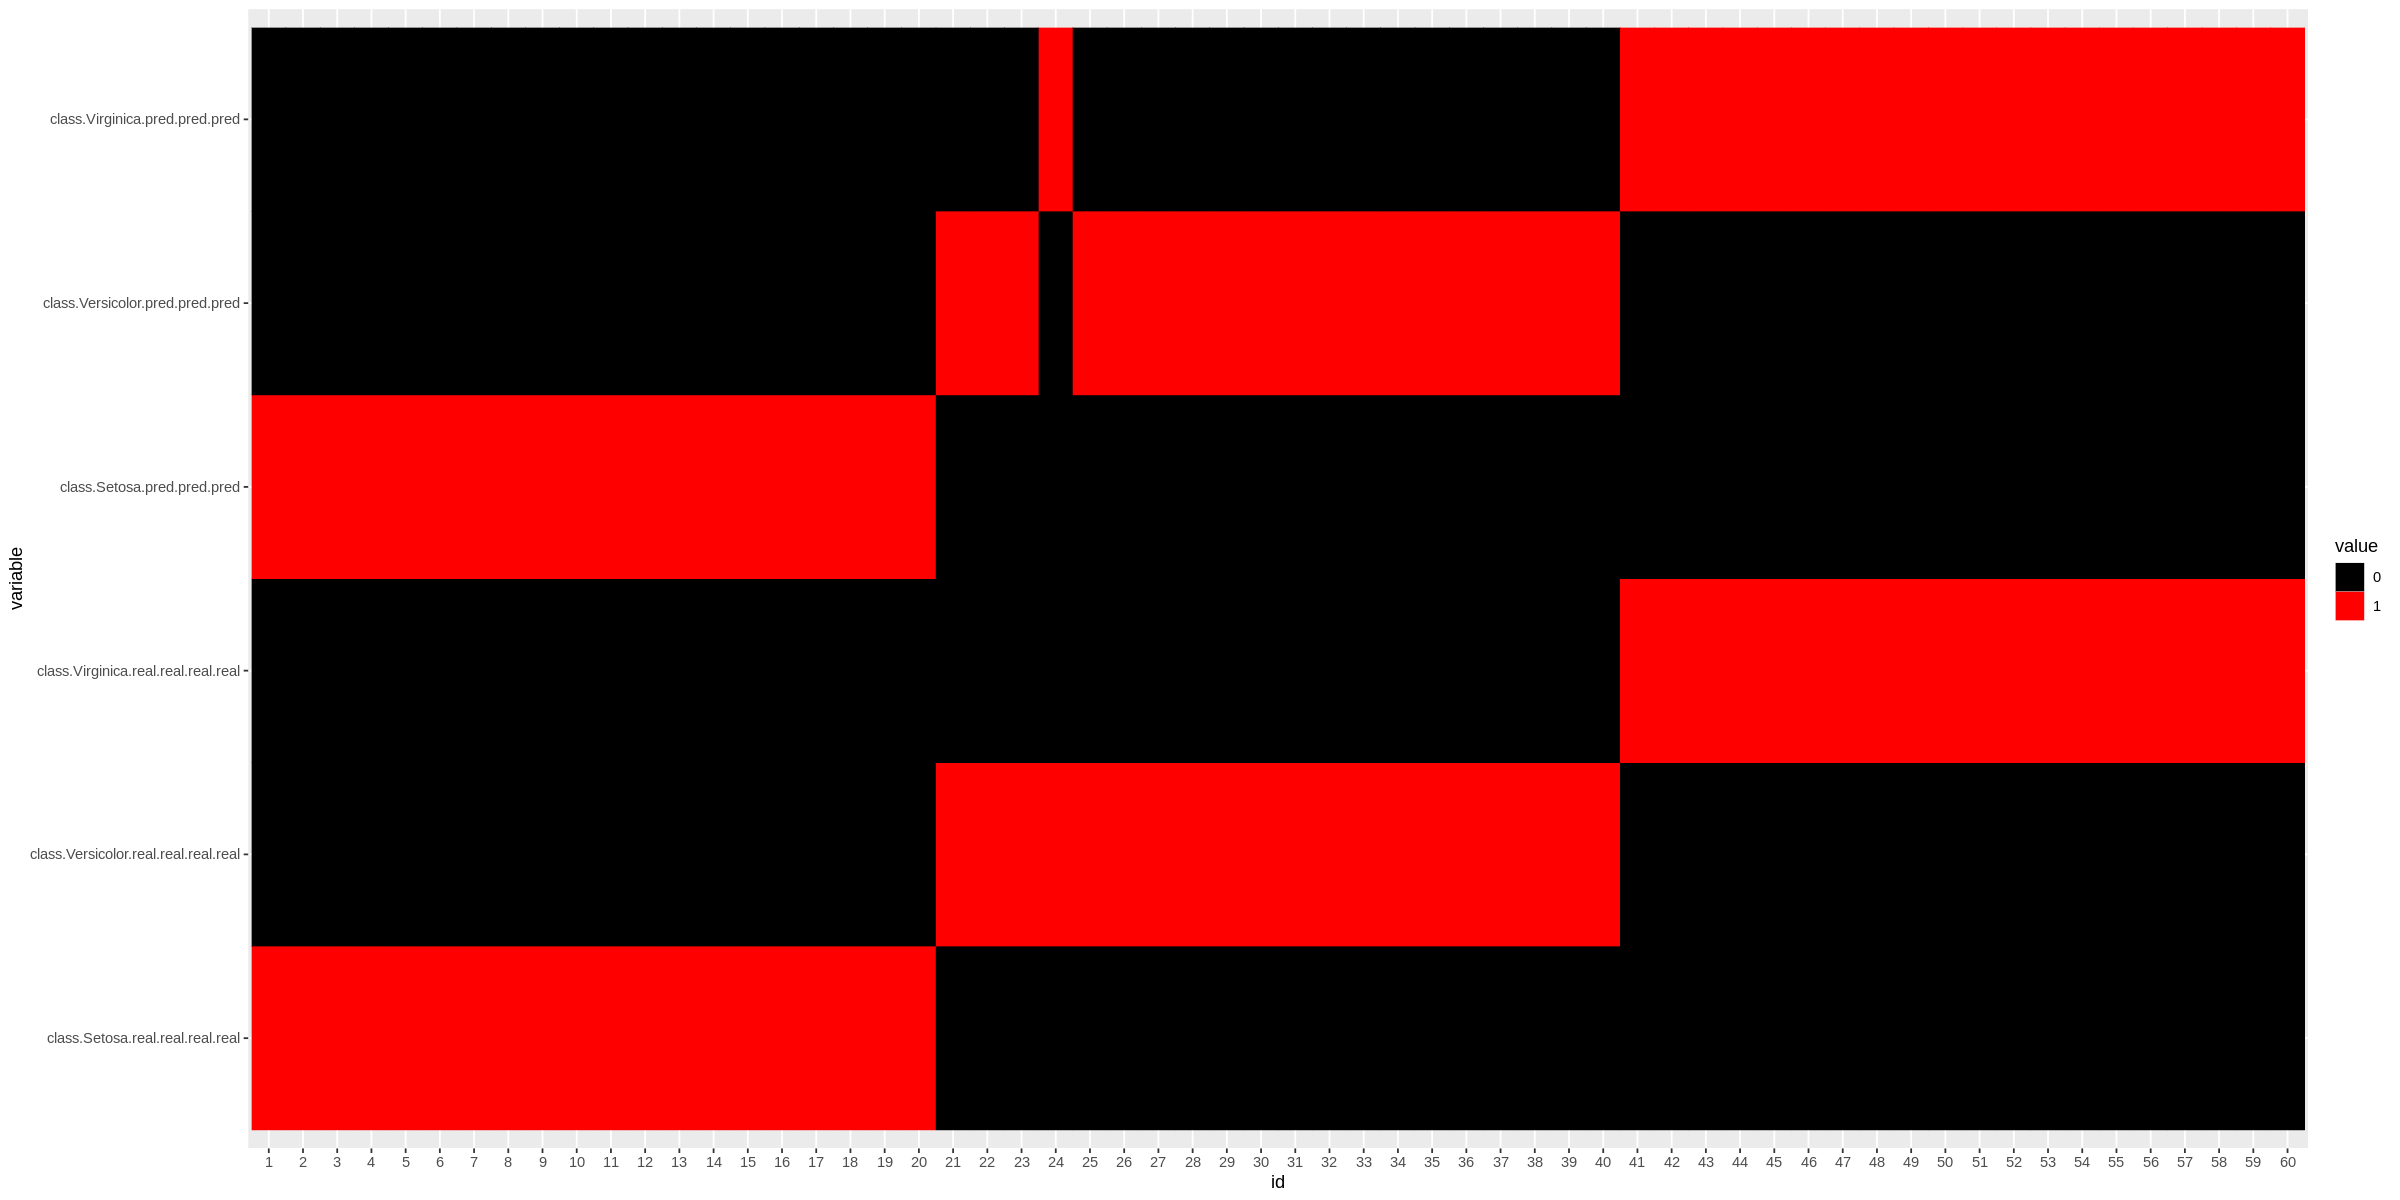

In [47]:
df.melt$id = as.factor(df.melt$id)
df.melt$value = as.factor(df.melt$value)

gg = ggplot(df.melt, aes(x = id, y = variable, fill = value, colour = value)) 
gg = gg + geom_tile()
gg = gg + scale_fill_manual(values = c("black", "red"))
gg = gg + scale_colour_manual(values = c("black", "red"))

options(repr.plot.width=20, repr.plot.height=10)
gg
